In [ ]:
!pip install datasets
!pip install wandb

In [ ]:
!pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install evaluate

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.ai.gato/registry/repository/pypi-proxy/simple
  Using cached http://repo.ai.gato/registry/repository/pypi-proxy/packages/fsspec/2024.9.0/fsspec-2024.9.0-py3-none-any.whl (179 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires numba-cuda<0.0.18,>=0.0.13, which is not installed.
s3fs 2025.2.0 requires fsspec==2025.2.0.*, but you have fsspec 2024.9.0 which is incompatible.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.0 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: hyobink1027 (hyobink1027-kookmin-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 데이터 전처리

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    BitsAndBytesConfig,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
import wandb


# 1. W&B 초기화 (학습 시작 직전에 실행)
wandb.init(project="KoT5_finetuning", name="kot5-finetune")

# 2. 데이터셋 불러오기 (KorQuAD)
korquad = load_dataset("KorQuAD/squad_kor_v1")
print(korquad)

# 3. QLoRA 설정 (4-bit 양자화)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

# 4. KoT5 모델 & 토크나이저 로드 (QLoRA 적용)
model_name = "wisenut-nlp-team/KoT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

# 5. LoRA 설정 (적용 모듈 추가)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q", "v"],
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

# 6. LoRA 적용 (순서 확인)
model = prepare_model_for_kbit_training(model)  # QLoRA 훈련 준비
model = get_peft_model(model, lora_config)  # LoRA 적용
model.print_trainable_parameters()  # trainable parameters 확인

# 7. 데이터 전처리 함수
def preprocess_function(examples):
    inputs = []
    outputs = []

    for question, context, answer_dict in zip(examples["question"], examples["context"], examples["answers"]):
        answer = answer_dict["text"][0]

        input_text = f"질문: {question} \n맥락: {context} \n정답을 생성하세요." + " " + tokenizer.eos_token
        output_text = f" {answer}" + " " + tokenizer.eos_token

        inputs.append(input_text)
        outputs.append(output_text)

    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding='max_length')
    labels = tokenizer(outputs, max_length=256, truncation=True, padding='max_length')["input_ids"]
    model_inputs["labels"] = [[(token if token != tokenizer.pad_token_id else -100) for token in seq] for seq in labels]

    return model_inputs

# 8. 전처리 적용
tokenized_korquad = korquad.map(preprocess_function, batched=True, remove_columns=korquad["train"].column_names)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 60407
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5774
    })
})
trainable params: 884,736 || all params: 223,788,288 || trainable%: 0.3953


## KorQuAD dataset
- 구조 : id, title, context, question, answer (답변의 시작 위치 포함)

## 모델 선택
처음에는 falcon-rw-1b 모델을 선택하고 finetuning을 진행하였다. 하지만 이 모델은 영어로 학습이 된 모델이라 글자가 깨지는 현상이 발생하였다.
따라서 한국어로 학습을 시킨 모델인 KoT5로 선정하였다.

### KoT5
T5(Text-to-Text Transfer Transformer)는 Google Research에서 개발한 모델로 모든 텍스트 기반 작업을 text-text 형식으로 변환하여 처리한다. Encoder-Decoder 구조로 이루어져 있다. Encoder는 input text를 처리하고 context를 이해하는데 사용되며, decoder는 encoder의 출력을 기반으로 새로운 text를 생성한다.T5는 text 분류, 번역, 질의응답, 요약 등 다양한 작업에서 뛰어난 성능을 보인다. KoT5는 T5를 한국어 데이터로 학습시킨 모델로, 한국어 text 분류, 번역, 질의응답 등 다양한 작업에 활용될 수 있다.

## QLoRA
QLoRA를 사용하여 4-bit quantization 설정을 구성하였다.
- load_in_4bit=True
    - 모델을 4-bit로 양자화하여 GPU 메모리 사용량을 대폭 감소
- bnb_4bit_quant_type="nf4"
    - NF4 (NormalFloat4): 4-bit 양자화 중에서도 높은 정밀도를 유지하는 포맷
- bnb_4bit_compute_dtype=torch.bfloat16
    - 연산 시 bfloat16을 사용해 속도와 정밀도의 균형을 맞춤
- bnb_4bit_use_double_quant=True
    - 추가 양자화 적용으로 메모리 사용량을 추가로 감소

QLoRA를 사용하여 메모리의 사용량을 줄이면서 성능 저하를 최소화하였다.

## LoRA
LoRA를 적용하여 일부 레이어만 finetuning하였다.
- r
    - rank 값으로, 적은 수의 파라미터만 업데이트
- lora_alpha
    - scaling 계수
- lora_dropout
    - dropout 적용
- target_modules=["q", "v"]
    - Attention layer의 query와 value에만 LoRA 적용
- bias="none"
    - 기존의 bias는 업데이트하지 않음
- task_type="SEQ_2_SEQ_LM"
    - 시퀀스-to-시퀀스 학습임을 명시
모델 전체를 학습시키지 않고 일부 레이어만 업데이트하여 메모리와 연산 비용을 줄였다.

## 입력 포맷 조정
프롬프트 형식으로 입력을 재구성하였고 KoT5에 맞게 question-context-answer를 토큰으로 변환하였다. PAD 토큰을 제거하여 Loss 계산의 정확성을 높였다.

기존 column(question, context, answer)를 제거 후, tokenized dataset 생성하였다.

In [ ]:
# 7. 학습 설정 (QLoRA에 맞는 learning_rate 조정)
training_args = Seq2SeqTrainingArguments(
    output_dir="./kot5-korquad",
    evaluation_strategy="steps",
    eval_steps=500,
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=1,
    predict_with_generate=True,
    report_to="wandb",
    logging_dir="./logs_kot5",
    logging_steps=50,
    run_name="kot5-korquad-finetune",
    warmup_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_checkpointing=True
)


# 8. Trainer 초기화
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_korquad["train"],
    eval_dataset=tokenized_korquad["validation"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early Stopping 적용
)

# 9. Fine-tuning 시작
trainer.train()

wandb.finish()


/usr/gatoai/python/venv/3.10/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_15918/2771610206.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
500,4.777800,4.893693
1000,0.667400,0.403998
1500,0.534200,0.318126
2000,0.499800,0.296151
2500,0.384300,0.294296
3000,0.327600,0.284961
3500,0.365300,0.267470
4000,0.426700,0.268030
4500,0.287200,0.271772
5000,0.266200,0.256603


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


eval/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▄▃▅▃▃▄▂▁▂▁▇▅▅█
eval/samples_per_second,▄▅▄▅▅▄▆▇▇█▂▃▃▁
eval/steps_per_second,▄▅▄▅▅▄▆▇▇█▂▃▃▁
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/grad_norm,▃█▃▂▃▃▆▄▄▂▅▄▁▄▁▂▄▄▇▂▄▂▄▁▂▁▃▂▃▆▂▃▃▁▁▃▂▃▃▃
train/learning_rate,▁▂▇██████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆
train/loss,████▆▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.25475
eval/runtime,352.4003


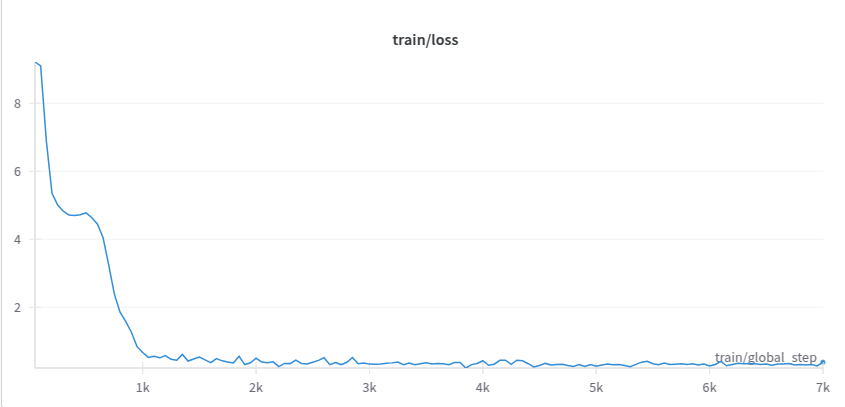

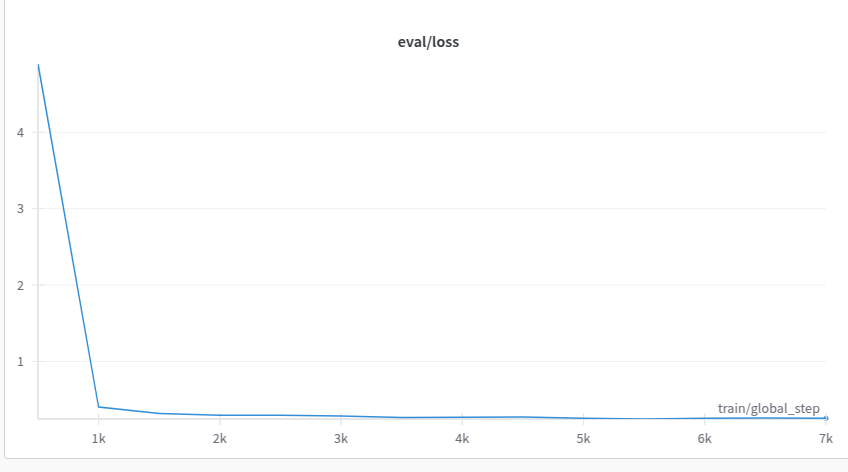

In [ ]:
def test_model(question, context):
    input_text = f"질문: {question} 문맥: {context}"
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=256, truncation=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = inputs.to(device)
    model.to(device)

    outputs = model.generate(input_ids=inputs, max_length=64, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Validation 데이터에서 1개 샘플 추출
sampled_data = korquad["validation"][0]

# 샘플 테스트
question = sampled_data["question"]
context = sampled_data[0]["context"]
true_answer = sampled_data[0]["answers"]["text"][0]

predicted_answer = test_model(question, context)

print(f"샘플 {i+1}")
print(f"question         : {question}")
print(f"context         : {context[:200]}...")
print(f"predicted_answer    : {predicted_answer}")
print(f"true_answer         : {true_answer}")
print("-" * 50)

🔹 샘플 1
question         : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
context         : 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 ...
predicted_answer    : 1989년 2월 15일 
true_answer         : 1989년 2월 15일
--------------------------------------------------


In [ ]:
# 추가 테스트
question = "아이폰16e는 얼마인가요?"
context = "아이폰16e는 99만원입니다."
print("predicted_answer:", test_model(question, context))


모델의 응답: 99만원 


### 느낀점

이번 과제를 수행하면서 데이터 전처리의 중요성을 다시 한 번 실감했다. 모델과, task에 적합한 방식으로 데이터 전처리하는 과정이 중요하다는 것을 직접 경험할 수 있었다.

일부 레이어만 finetuning할 수 있는 LoRA를 새롭게 알게 되었다. LoRA는 전체 모델을 업데이트하지 않고도 적은 리소스로 효과적인 파인튜닝이 가능하다는 점에서 매우 실용적이라고 느꼈다. 또한 QLoRA에 대해서도 알게 되었는데, 기존 LoRA보다 메모리 사용량을 더욱 줄이면서도 유사한 성능을 유지할 수 있다는 점이 흥미로웠다.

이번 과제를 통해 데이터 전처리의 중요성과 효율적인 finetuning 기법을 깊이 이해할 수 있었으며, 앞으로 다양한 프로젝트에서 이러한 기술들을 적극 활용할 계획이다.